# CONNECT 4

## Informações Gerais

**Unidade Curricular:** Inteligência Artificial

**Turma:** PL6

**Grupo 2:**
- Hugo Duarte de Sousa — nº 202305900
- Isabela Britto Cartaxo — nº 202300339
- Tiago Figueredo Silva — nº 202000612

## Sumário

1. Introdução  
2. Objetivos  
3. Lógica do Jogo e Estrutura do Tabuleiro  
4. Monte Carlo Tree Search  
5. Geração do Dataset — Connect Four IA vs IA (MCTS)  
6. Decision Tree  
7. Avaliação do DT contra MCTS  
8. Conclusão sobre o desempenho final  
9. Implementação Final do Jogo


## 1. Introdução

Este trabalho foi desenvolvido no âmbito da unidade curricular de Inteligência Artificial (2024/2025) e tem como principal finalidade a aplicação de estratégias de procura adversária e algoritmos de aprendizagem supervisionada, com enfoque nas árvores de decisão. O projeto encontra-se dividido em duas componentes principais:

A implementação do algoritmo Monte Carlo Tree Search (MCTS) com a fórmula UCT, aplicado ao jogo Connect Four (Quatro em Linha), um clássico de estratégia entre dois jogadores.

A construção de um classificador baseado em árvores de decisão, recorrendo ao algoritmo ID3, treinado com dois conjuntos de dados distintos: o conhecido dataset Iris e um dataset gerado a partir de simulações com o MCTS no jogo Connect Four.

Este trabalho tem como intuito consolidar os conhecimentos teóricos abordados nas aulas, promovendo a sua aplicação prática em contextos desafiantes de tomada de decisão, planeamento e aprendizagem automática.

### O jogo Connect Four
O Connect Four (ou Quatro em Linha) é um jogo de estratégia para dois jogadores, jogado num tabuleiro vertical com 7 colunas e 6 linhas. Cada jogador tem 21 peças da sua cor (normalmente vermelho e amarelo), e o objetivo do jogo é ser o primeiro a alinhar quatro peças consecutivas na horizontal, vertical ou diagonal.

Os jogadores jogam alternadamente, inserindo uma peça numa das colunas. A peça cai até ocupar a posição mais baixa disponível nessa coluna. O jogo termina quando um dos jogadores vence ou quando o tabuleiro está cheio, resultando num empate.

## 2. Objetivos

- Implementar um agente capaz de jogar Connect Four utilizando o algoritmo MCTS com UCT.

- Suportar diferentes modos de jogo: humano vs. humano, humano vs. computador e computador vs. computador (com estratégias distintas).

- Implementar o algoritmo ID3 para gerar árvores de decisão a partir de dados, sem recorrer a bibliotecas externas como o scikit-learn.

- Avaliar a performance das árvores de decisão utilizando:

- O dataset Iris.

- Um dataset gerado artificialmente a partir da execução do MCTS no Connect Four, contendo pares (estado do jogo, jogada recomendada).

- Documentar as decisões tomadas, discutir os resultados obtidos.

## 3. Lógica do Jogo e Estrutura do Tabuleiro

A lógica do jogo Connect Four foi implementada através da classe Board, que representa o estado atual do tabuleiro, permite realizar jogadas, verificar jogadas legais e determinar se o jogo terminou com vitória ou empate.

### Estrutura do tabuleiro
O tabuleiro é representado por uma matriz de 6 linhas e 7 colunas (6x7), modelada como uma lista de listas de strings. Cada posição pode conter:

- "." – casa vazia

- "X" – peça do jogador 1

- "O" – peça do jogador 2

A matriz é inicializada com todas as casas vazias, e as peças "caem" até à posição mais baixa disponível em cada coluna, respeitando as regras do jogo real.

### Componentes principais da implementação
- self.board: Matriz 6x7 que guarda o estado atual do tabuleiro.

- self.y_coords: Dicionário que indica a próxima linha disponível em cada coluna, permitindo simular a gravidade.

- self.counter: Contador de jogadas realizadas (máximo 42).

- make_move(x, current_player): Realiza uma jogada válida, atualizando o tabuleiro e o estado interno.

- is_legal_move(x): Verifica se a jogada na coluna x é legal (coluna dentro dos limites e com espaço disponível).

- is_board_full(): Verifica se o tabuleiro está cheio.

- is_won(x, current_player): Verifica se a última jogada feita na coluna x resultou numa vitória para o jogador atual.

- is_tie(): Verifica se o jogo terminou empatado.

- get_possible_moves(current_player): Devolve todos os possíveis estados do tabuleiro resultantes de uma jogada válida do jogador atual (útil para o algoritmo MCTS).

In [1]:
from copy import deepcopy

class Board:
    def __init__(self):
        """
        Initializes the Connect Four board.
        - 6 rows x 7 columns represented by a list of lists.
        - y_coords stores the next available row index for each column.
        """
        self.counter = 0
        self.board_width = 7
        self.board_height = 6
        self.board = [list(".......") for _ in range(self.board_height)]
        self.y_coords = {col: self.board_height - 1 for col in range(self.board_width)}
        self.last_move_column = None

    def to_tuple(self):
        """
        Returns an immutable representation of the board (useful for hashing).
        """
        return tuple(tuple(row) for row in self.board)

    def get_simulation_board(self):
        """
        Placeholder for compatibility or extensions (e.g., for neural network input).
        """
        return []

    def print_board(self):
        """
        Displays the board to the console.
        """
        print("\n" + " ".join(map(str, [1, 2, 3, 4, 5, 6, 7])))
        for row in self.board:
            print(" ".join(row))
        print()

    def is_empty(self, x, y) -> bool:
        """
        Checks if a given cell is empty.
        """
        return self.board[y][x] == "."

    def is_board_full(self) -> bool:
        """
        Checks if the board is full (42 moves).
        """
        return self.counter == 42

    def is_legal_move(self, x) -> bool:
        """
        Checks if a move is legal:
        - Column must be within bounds.
        - Column must not be full.
        """
        if self.is_board_full():
            return False
        if not 0 <= x < self.board_width:
            return False
        if self.y_coords[x] < 0:
            return False
        return self.is_empty(x, self.y_coords[x])

    def make_move(self, x, current_player):
        """
        Places a piece from the current player in the specified column.
        Updates the board, move counter, and last played column.
        """
        y = self.y_coords[x]
        self.board[y][x] = current_player
        self.counter += 1
        self.y_coords[x] -= 1
        self.last_move_column = x

    def count_in_direction(self, current_player, dx, dy, x, y):
        """
        Counts how many consecutive pieces exist in a given direction from (x, y).
        """
        count = 0
        while (0 <= x + dx < self.board_width and 
               0 <= y + dy < self.board_height and 
               self.board[y + dy][x + dx] == current_player):
            x += dx
            y += dy
            count += 1
        return count

    def is_won(self, x, current_player) -> bool:
        """
        Checks whether the last move in column x resulted in a win.
        """
        directions = [((0, 1), (0, -1)),      # Horizontal
                      ((1, 0), (-1, 0)),      # Vertical
                      ((1, 1), (-1, -1)),     # Main diagonal
                      ((1, -1), (-1, 1))]     # Anti-diagonal

        y = self.y_coords[x] + 1  # Find the row where the last move was placed
        if y is None:
            return False
        for (dy1, dx1), (dy2, dx2) in directions:
            total = (self.count_in_direction(current_player, dx1, dy1, x, y) +
                     self.count_in_direction(current_player, dx2, dy2, x, y) + 1)
            if total >= 4:
                return True
        return False

    def has_winner(self) -> bool:
        """
        Scans the board to detect if there is a winning sequence for any player.
        Used in end-of-game checks (e.g., for tie).
        """
        for y in range(self.board_height):
            for x in range(self.board_width):
                if self.board[y][x] in ["X", "O"]:
                    current_player = self.board[y][x]
                    for (dx1, dy1), (dx2, dy2) in [((0, 1), (0, -1)),
                                                  ((1, 0), (-1, 0)),
                                                  ((1, 1), (-1, -1)),
                                                  ((1, -1), (-1, 1))]:
                        count = 1
                        count += self.count_in_direction(current_player, dx1, dy1, x, y)
                        count += self.count_in_direction(current_player, dx2, dy2, x, y)
                        if count >= 4:
                            return True
        return False

    def is_tie(self) -> bool:
        """
        Returns True if the board is full and there is no winner.
        """
        return self.is_board_full() and not self.has_winner()

    def get_possible_moves(self, current_player):
        """
        Returns a list of possible future board states given the current player's move.
        Useful for MCTS simulation.
        """
        possible_boards = []
        for i in range(self.board_width):
            if self.is_legal_move(i):
                new_board = deepcopy(self)   # NOT USE DEEP COPY, RETURN POSSIBLE MOVES INSTEAD, I.E. [1,3,4,5,6]
                new_board.make_move(i, current_player)
                possible_boards.append(new_board)
        return possible_boards
    
    def get_legal_moves(self):
        """
        Returns a list of column indices where a move is legal (i.e., the column is not full).
        """
        possible_boards = []
        legal_moves = []
        for col in range(self.board_width):
            if self.is_legal_move(col):
                legal_moves.append(col)
        return legal_moves


## 4. Monte Carlo Tree Search

Nesta secção, apresentamos a implementação do algoritmo **Monte Carlo Tree Search (MCTS)**, utilizado como estratégia de decisão para o jogo Connect Four.

O MCTS baseia-se em simulações aleatórias para explorar o espaço de estados do jogo e selecionar as jogadas mais promissoras. A cada iteração, o algoritmo executa quatro fases principais:

1. **Seleção**: navega pela árvore de decisão até um nó que ainda não esteja totalmente expandido.
2. **Expansão**: adiciona um novo nó filho a partir de uma jogada possível ainda não explorada.
3. **Simulação**: executa uma partida aleatória a partir do novo estado até ao final do jogo.
4. **Retropropagação**: propaga o resultado da simulação para os nós ancestrais, atualizando os valores de vitória e visita.


### Estrutura do Nó (Node)

A classe Node representa um estado na árvore de MCTS. Cada nó contém o estado atual do tabuleiro, uma ligação ao nó pai, os seus filhos, e estatísticas que guiam o algoritmo de seleção.


In [2]:
import math

class Node:
    def __init__(self, board, parent=None):
        """
        Initializes a node representing a game state in the MCTS tree.

        Parameters:
        - board: The game board associated with this node.
        - parent: The parent node in the tree (None if this is the root).
        """
        self.board = board
        self.parent = parent
        self.children = []
        self.wins = 0
        self.visits = 0

    def is_fully_expanded(self) -> bool:
        """
        Returns True if all possible moves from this state have been expanded into children.
        """
        return len(self.children) == len(self.board.get_possible_moves("X"))  # or "O" if alternating

    def best_child(self):
        """
        Returns the child node with the highest UCT (Upper Confidence Bound for Trees) value.
        Used to select the most promising node during the selection phase of MCTS.
        """
        return max(self.children, key=lambda child: child.get_uct_value())

    def add_child(self, child):
        """
        Adds a new child node to this node.
        """
        self.children.append(child)

    def get_uct_value(self, c=1.4) -> float:
        """
        Calculates the UCT value for this node, balancing exploration and exploitation.
        """
        exploitation = self.wins / (self.visits + 1e-6)
        exploration = c * math.sqrt(math.log(self.parent.visits + 1) / (self.visits + 1e-6))
        return exploitation + exploration


### Estrutura do MCTS

A classe MCTS encapsula toda a lógica do algoritmo. Abaixo, destacamos os principais métodos implementados:

- selection()  
  Seleciona o melhor caminho atual com base nos valores de UCT.

- expansion(node)  
  Cria todos os filhos possíveis para um dado nó, representando as próximas jogadas válidas.

- simulation(node)  
  Executa uma simulação aleatória até o fim do jogo, retornando o vencedor ou empate.

- backpropagation(node, result)  
  Atualiza estatísticas (vitórias e visitas) com base no resultado da simulação.

- check_for_win(leaf)  
  Verifica se existe uma jogada imediata que leva à vitória — se existir, executa essa jogada diretamente (acelera o processo).

- best_move()  
  Executa o ciclo completo do MCTS (seleção, expansão, simulação, retropropagação) um número de vezes definido por simulation_limit, e retorna o melhor nó filho da raiz.


In [3]:
import random
from copy import deepcopy

class MCTS:
    def __init__(self, initial_state, current_player, simulation_limit=10000):
        """
        Initializes the MCTS agent.

        Parameters:
        - initial_state: The root node containing the current game state.
        - current_player: The player for whom the move is being calculated.
        - simulation_limit: Maximum number of simulations to run (default: 10000).
        """
        self.root = initial_state
        self.simulation_limit = simulation_limit
        self.current_player = current_player

    def selection(self):
        """
        Selects the most promising node by traversing the tree
        using the UCT value until a leaf is reached.
        """
        node = self.root
        while node.children:
            node = node.best_child()
        return node

    def expansion(self, node):
        """
        Expands the given node by generating all possible child states.
        """
        current_player = self.current_player
        for board in node.board.get_possible_moves(current_player):
            new_node = Node(board, parent=node)
            node.add_child(new_node)

    def simulation(self, node):
        """
        Simulates a random playout from the current node until
        the game ends with a win or a tie.
        """
        sim_board = deepcopy(node.board)
        player = "O" if self.current_player == "X" else "X"

        while not sim_board.is_board_full():
            legal_moves = [i for i in range(sim_board.board_width) if sim_board.is_legal_move(i)]
            move = random.choice(legal_moves)
            sim_board.make_move(move, player)

            if sim_board.is_won(move, player):
                return player

            player = "O" if player == "X" else "X"

        return "."

    def backpropagation(self, node, result):
        """
        Updates the statistics of the nodes on the path from the
        simulation result back to the root.
        """
        while node is not None:
            node.visits += 1
            if result == self.current_player:
                node.wins += 1
            elif result == ".":
                node.wins += 0.5
            node = node.parent

    def check_for_win(self, leaf) -> Node:
        """
        Checks if there is an immediate winning move for the current player.
        If found, returns a new node representing that winning move.
        """
        possible_moves = [i for i in range(leaf.board.board_width) if leaf.board.is_legal_move(i)]

        for i in possible_moves:
            simulated_board = deepcopy(leaf.board)
            simulated_board.make_move(i, self.current_player)
            if simulated_board.is_won(i, self.current_player):
                return Node(simulated_board, parent=leaf)

        return None

    def best_move(self):
        """
        Runs the full MCTS process and returns the best child of the root node.
        """
        leaf = self.selection()
        if not leaf.children:
            self.expansion(leaf)

        winning_node = self.check_for_win(leaf)
        if winning_node:
            return winning_node

        for child in leaf.children:
            result = self.simulation(child)
            self.backpropagation(child, result)

        children = leaf.children

        for _ in range(7, self.simulation_limit + 1):
            selected_leaf = random.choice(children)
            result = self.simulation(selected_leaf)
            self.backpropagation(selected_leaf, result)

        return self.root.best_child()


### Execução da simulação

Este é um exemplo de demonstração de uma simulação entre dois agentes inteligentes baseados no algoritmo MCTS, utilizando a função ai_vs_ai(). Nesta função, o número de simulações por jogada pode ser ajustado através dos parâmetros x_simulation_limit e o_simulation_limit, permitindo observar o impacto da profundidade da busca no desempenho de cada IA.

Sinta-se à vontade para experimentar diferentes valores de limite de simulação para comparar os tempos de execução e a qualidade das decisões tomadas por cada agente.

In [4]:
import time

def ai_vs_ai(x_simulation_limit=10000, o_simulation_limit=10000):
    """
    AI vs. AI game loop.
    """
    game = Board()
    players = ["X", "O"]
    current_index = 0
    game_over = False

    while not game.is_board_full() and not game_over:
        current_player = players[current_index]
        game.print_board()
        print(f"It is now {current_player}'s turn!")

        sim_limit = x_simulation_limit if current_player == "X" else o_simulation_limit
        root = Node(game, None)
        mcts = MCTS(root, current_player, sim_limit)
        start = time.time()
        best_node = mcts.best_move()
        move = best_node.board.last_move_column
        game.make_move(move, current_player)
        print(move)
        end = time.time()

        print(f"{current_player} chose column: {move + 1}\nTime taken: {end - start:.2f}s")
        game_over = game.is_won(move, current_player)
        current_index = 1 - current_index

    game.print_board()
    print("It's a tie!" if game.is_tie() else f"Player {current_player} has won!\n")


In [5]:
ai_vs_ai(x_simulation_limit=10000, o_simulation_limit=10000)


1 2 3 4 5 6 7
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .

It is now X's turn!
3
X chose column: 4
Time taken: 1.93s

1 2 3 4 5 6 7
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . X . . .

It is now O's turn!
2
O chose column: 3
Time taken: 1.80s

1 2 3 4 5 6 7
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . O X . . .

It is now X's turn!
3
X chose column: 4
Time taken: 1.78s

1 2 3 4 5 6 7
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . X . . .
. . O X . . .

It is now O's turn!
3
O chose column: 4
Time taken: 1.65s

1 2 3 4 5 6 7
. . . . . . .
. . . . . . .
. . . . . . .
. . . O . . .
. . . X . . .
. . O X . . .

It is now X's turn!
2
X chose column: 3
Time taken: 1.67s

1 2 3 4 5 6 7
. . . . . . .
. . . . . . .
. . . . . . .
. . . O . . .
. . X X . . .
. . O X . . .

It is now O's turn!
2
O chose column: 3
Time taken: 1.54s

1 2 3 4 5 6 7
. . . . . . .
. . . . . . .
. . . . .

### Avaliação do MCTS contra jogador aleatório

Para avaliar o desempenho do agente baseado em MCTS (Monte Carlo Tree Search), realizamos 50 partidas contra um agente que escolhe jogadas de forma totalmente aleatória. O MCTS jogou sempre como o jogador "X", iniciando a partida, enquanto o oponente aleatório jogou como "O".

Durante os testes, foram registradas:

A quantidade de vitórias, derrotas e empates.

O tempo médio de decisão por jogada do MCTS.

Esse experimento permite observar a eficiência estratégica do MCTS em um cenário com mínima complexidade adversária, servindo como uma linha de base para comparações futuras com agentes mais inteligentes, como o modelo de árvore de decisão treinado.

In [6]:
import time
import numpy as np

def mcts_vs_random_simulation(simulation_limit=10000, num_games=50):
    """
    Simulates multiple games between MCTS (X) and Random agent (O),
    and returns detailed statistics.
    """
    mcts_wins = 0
    random_wins = 0
    ties = 0
    mcts_move_times = []
    results = []

    for game_idx in range(1, num_games + 1):
        game = Board()
        current_player = "X"
        game_over = False
        winner = None

        print(f"Game {game_idx}/{num_games}")

        while not game.is_board_full() and not game_over:
            if current_player == "X":
                # MCTS turn
                start = time.time()
                root = Node(game, None)
                mcts = MCTS(root, "X", simulation_limit)
                best_node = mcts.best_move()
                end = time.time()

                move = best_node.board.last_move_column
                mcts_move_times.append(end - start)
            else:
                # Random turn
                valid_moves = game.get_legal_moves()
                move = np.random.choice(valid_moves)

            game.make_move(move, current_player)
            game_over = game.is_won(move, current_player)

            if game_over:
                winner = current_player

            current_player = "O" if current_player == "X" else "X"

        if game.is_tie():
            ties += 1
            results.append("Draw")
        elif winner == "X":
            mcts_wins += 1
            results.append("MCTS wins")
        else:
            random_wins += 1
            results.append("Random wins")

    # Summary
    avg_time = np.mean(mcts_move_times) if mcts_move_times else 0

    print("\nFinal Summary:")
    print(f"Total games: {num_games}")
    print(f"MCTS wins: {mcts_wins}")
    print(f"Random wins: {random_wins}")
    print(f"Draws: {ties}")
    print(f"Average MCTS move time: {avg_time:.4f} seconds")

    return {
        "total_games": num_games,
        "mcts_wins": mcts_wins,
        "random_wins": random_wins,
        "draws": ties,
        "average_mcts_time": avg_time,
        "game_results": results
    }


In [7]:
stats_mcts_random = mcts_vs_random_simulation(simulation_limit=5000, num_games=50)

Game 1/50
Game 2/50
Game 3/50
Game 4/50
Game 5/50
Game 6/50
Game 7/50
Game 8/50
Game 9/50
Game 10/50
Game 11/50
Game 12/50
Game 13/50
Game 14/50
Game 15/50
Game 16/50
Game 17/50
Game 18/50
Game 19/50
Game 20/50
Game 21/50
Game 22/50
Game 23/50
Game 24/50
Game 25/50
Game 26/50
Game 27/50
Game 28/50
Game 29/50
Game 30/50
Game 31/50
Game 32/50
Game 33/50
Game 34/50
Game 35/50
Game 36/50
Game 37/50
Game 38/50
Game 39/50
Game 40/50
Game 41/50
Game 42/50
Game 43/50
Game 44/50
Game 45/50
Game 46/50
Game 47/50
Game 48/50
Game 49/50
Game 50/50

Final Summary:
Total games: 50
MCTS wins: 50
Random wins: 0
Draws: 0
Average MCTS move time: 0.6489 seconds


O agente MCTS demonstrou um desempenho excepcional ao vencer todas as 50 partidas contra o agente aleatório. Esse resultado era esperado, já que o MCTS realiza milhares de simulações por jogada e toma decisões baseadas em estimativas estatísticas de vitória, enquanto o agente aleatório não possui qualquer estratégia ou aprendizado.

Esse teste comprova que o algoritmo MCTS é altamente eficaz mesmo com um número limitado de simulações (ex: 5.000 por jogada) e é capaz de explorar de forma eficiente o espaço de possibilidades para obter vitórias consistentes.

Embora esse cenário represente um oponente trivial, ele serve como uma prova de conceito importante para validar o funcionamento correto do MCTS antes de confrontá-lo com adversários mais desafiadores.

## 5. Geração do Dataset — Connect Four IA vs IA (MCTS)

Para treinar nosso modelo de árvore de decisão, foi necessário gerar um conjunto de dados supervisionado contendo exemplos de jogadas consideradas ótimas em diferentes situações de jogo. Essa geração foi realizada por meio da função ai_vs_ai_simulation_generator, descrita abaixo.

Essa função simula partidas completas de Connect Four entre dois agentes que utilizam o algoritmo Monte Carlo Tree Search (MCTS), cada um com um número configurável de simulações por jogada. A cada jogada, o estado atual do tabuleiro é registrado junto ao jogador da vez (X ou O) e à coluna escolhida como a melhor jogada segundo o MCTS.

In [8]:
import time
import numpy as np

def ai_vs_ai_simulation_generator(x_simulation_limit=10000, o_simulation_limit=10000):
    """
    Simulates a Connect Four game between two AI agents using MCTS with configurable simulation limits.

    Returns:
    - boardStates: A list of flattened 1D arrays representing the state of the board at each move
    - playerTurns: A list of strings ("X" or "O") indicating the player who made each move
    - optimalMoves: A list of integers indicating the column (1-based) chosen at each move
    """
    game = Board()
    players = ["X", "O"]
    current_index = 0
    game_over = False

    boardStates = []
    playerTurns = []
    optimalMoves = []

    while not game.is_board_full() and not game_over:
        current_player = players[current_index]

        sim_limit = x_simulation_limit if current_player == "X" else o_simulation_limit
        root = Node(game, None)
        mcts = MCTS(root, current_player, sim_limit)
        start = time.time()
        best_node = mcts.best_move()
        move = best_node.board.last_move_column
        end = time.time()

        # Register move and state
        flat_board = np.array(game.board).flatten().tolist()
        boardStates.append(flat_board)
        playerTurns.append(current_player)
        optimalMoves.append(move + 1)  # 1-based index for readability

        game.make_move(move, current_player)

        game_over = game.is_won(move, current_player)
        current_index = 1 - current_index

    return boardStates, playerTurns, optimalMoves

### Estrutura do ficheiro CSV
O ficheiro gerado contém 44 colunas no total:

- Colunas 1 a 42: Estado do tabuleiro achatado (6x7) — preenchido linha a linha

- Coluna 43: player_turn — o jogador que fez a jogada ("X" ou "O")

- Coluna 44: chosen_move — coluna escolhida pelo algoritmo MCTS (base 1, de 1 a 7)

Cada linha representa uma jogada dentro de um jogo. 

In [9]:
import numpy as np
import csv
import os

def run_simulation(simulation_limit):
    """
    Executes a single simulation of a Connect Four match using two AI agents (MCTS).

    Returns:
    - boardStates: A list of 1D arrays representing the state of the board at each move
    - playerTurns: A list indicating which player ("X" or "O") made each move
    - optimalMoves: A list of the moves chosen by the agents at each step
    """
    boardStates, playerTurns, optimalMoves = ai_vs_ai_simulation_generator(simulation_limit, simulation_limit)
    return boardStates, playerTurns, optimalMoves

def generate_db_csv(folder="datasets", filename="connect4_dataset.csv", iterations=150, append=True, simulation_limit=10000):
    """
    Generates a dataset by simulating multiple Connect Four games and logging the results
    into a CSV file inside a specific folder.

    Parameters:
    - folder: Folder to store the CSV file (e.g., "datasets" or "data")
    - filename: Name of the CSV file
    - iterations: Number of games to simulate
    - append: Whether to append to the existing file or overwrite it
    """
    os.makedirs(folder, exist_ok=True)  # Create folder if it doesn't exist
    filepath = os.path.join(folder, filename)
    
    file_exists = os.path.isfile(filepath)
    mode = 'a' if append else 'w'

    with open(filepath, mode, newline='') as csvfile:
        writer = csv.writer(csvfile)

        # Write header if file is new or being overwritten
        if not file_exists or not append:
            header = [f"cell_{i+1}" for i in range(42)] + ["player_turn", "chosen_move"]
            writer.writerow(header)

        for i in range(iterations):
            print(f"Initiating simulation {i + 1}:")
            boardStates, playerTurns, optimalMoves = run_simulation(simulation_limit)

            for state, player, move in zip(boardStates, playerTurns, optimalMoves):
                row = list(state) + [player, move]
                writer.writerow(row)

            print(f"Simulation {i + 1} completed!")
            print(f"Progress: { round(((i + 1)/iterations) * 100, 2)}%")
            print("")

### Exemplo de geração do dataset

Este script simula partidas completas de Connect Four entre dois agentes de IA utilizando o algoritmo MCTS (Monte Carlo Tree Search). Cada jogada é escolhida com base em 5.000 simulações (valor configurável).

No dataset original, foram gerados 500 jogos, e os dados resultantes foram gravados em um ficheiro .csv estruturado, ideal para treino ou análise posterior.

Abaixo, apresentamos um exemplo de como o dataset foi gerado utilizando partidas entre dois agentes de IA com o algoritmo MCTS (Monte Carlo Tree Search).

Para fins de demonstração, limitamos a geração a apenas 5 jogos, pois simular as 500 partidas completas leva um tempo considerável devido à complexidade do algoritmo (5.000 simulações por jogada).

No entanto, se desejar gerar um dataset maior, basta alterar o valor do parâmetro iterations na função generate_db_csv.

**Nota**: O dataset utilizado para treinar o Decision Tree foi gerado com 500 simulações, garantindo uma base mais robusta e representativa para o aprendizado do modelo.

In [10]:
generate_db_csv(folder="datasets", filename="connect4_dataset_example.csv", iterations=5, append=True, simulation_limit=5000)

Initiating simulation 1:
Simulation 1 completed!
Progress: 20.0%

Initiating simulation 2:
Simulation 2 completed!
Progress: 40.0%

Initiating simulation 3:
Simulation 3 completed!
Progress: 60.0%

Initiating simulation 4:
Simulation 4 completed!
Progress: 80.0%

Initiating simulation 5:
Simulation 5 completed!
Progress: 100.0%



# 6. Decision Tree

Após gerar nosso dataset com simulações de partidas de Connect Four utilizando MCTS, o próximo passo é construir um modelo que consiga aprender os padrões dessas jogadas e tomar decisões semelhantes. Para isso, vamos utilizar uma árvore de decisão, um dos algoritmos mais interpretáveis e intuitivos da aprendizagem supervisionada.

A árvore de decisão será treinada para prever a melhor jogada (coluna) com base no estado atual do tabuleiro e no jogador da vez. Cada nó da árvore fará uma divisão (split) nos dados com base em um dos atributos do tabuleiro, buscando separar os exemplos da forma mais "pura" possível (por exemplo, agrupando situações que levam a uma mesma jogada ideal).

### Estrutura do Nó (Node)

Antes de construir a árvore propriamente dita, é importante definir como será representado cada nó da árvore. Para isso, criamos a classe Node_DT.

Essa classe representa um único ponto de decisão ou previsão na árvore:

In [11]:
class NodeDT:
    def __init__(self, feature=None, split_criteria=None, left=None, right=None, value=None):
        """
        Initializes a node for a Decision Tree.

        Parameters:
        - feature: The feature used to split the data at this node (e.g., "number of rooms").
        - split_criteria: The threshold value for splitting (e.g., <= 5 goes left, > 5 goes right).
        - left: The left child node (corresponds to data satisfying the split condition).
        - right: The right child node (corresponds to data not satisfying the split condition).
        - value: The predicted value or class if this node is a leaf.
        """
        self.feature = feature
        self.split_criteria = split_criteria
        self.left = left
        self.right = right
        self.value = value
        self.children = {}  # For potential extension to multi-branch trees (e.g., categorical splits)

    def is_leaf(self) -> bool:
        """
        Returns True if the node is a leaf (i.e., it holds a prediction value and has no children).
        """
        return self.value is not None


### Estrutura do classificador decision tree

Nesta etapa, implementamos a classe DecisionTree, responsável por aprender as melhores jogadas a partir do dataset gerado com partidas entre agentes MCTS.

A árvore é construída de forma recursiva, dividindo os dados com base no ganho de informação até atingir a profundidade máxima ou outros critérios de parada.

Principais métodos:

- grow_tree(): Função principal que constrói a árvore recursivamente.

- best_split(): Itera sobre os atributos disponíveis e retorna a melhor divisão possível.

- information_gain(): Calcula o ganho de informação para a divisão escolhida.

- split(): Função auxiliar que separa os dados em subconjuntos com base no atributo escolhido.

- entropy(): Função auxiliar que retorna a entropia do conjunto de dados.

- predict(): Função auxiliar que percorre a árvore para fazer previsões.

- traverse_tree(): Função recursiva que percorre a árvore para um exemplo de teste e retorna a predição.

In [12]:
from collections import Counter

class DecisionTree:
    def __init__(self, min_sample_split=2, max_depth=15, n_features=None) -> None:
        """
        Initializes the Decision Tree classifier.

        Parameters:
        - min_sample_split: Minimum number of samples required to split an internal node.
        - max_depth: Maximum depth allowed for the tree.
        - n_features: Number of features to consider when looking for the best split.
        """
        self.min_sample_split = min_sample_split
        self.max_depth = max_depth
        self.n_features = n_features
        self.root = None

    def fit(self, X, y):
        """
        Fits the Decision Tree to the training data by building the tree recursively.
        """
        self.n_features = X.shape[1]
        self.root = self.grow_tree(X, y)

    def grow_tree(self, X, y, depth=0):
        """
        Recursively builds the decision tree.
        """
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))

        # Stopping conditions
        if (depth >= self.max_depth or n_labels == 1 or n_samples < self.min_sample_split):
            leaf_value = self.most_common_label(y)
            return NodeDT(value=leaf_value)

        best_feature, best_value = self.best_split(X, y, list(range(n_feats)))

        node = NodeDT(feature=best_feature)

        for value in np.unique(X.iloc[:, best_feature]):
            idxs = self.split(X.iloc[:, best_feature], value)
            if len(idxs) > 0:
                node.children[value] = self.grow_tree(
                    X.iloc[idxs, :],
                    y.iloc[idxs],
                    depth + 1
                )

        return node

    def most_common_label(self, y):
        """
        Returns the most common label in the target array y.
        """
        counter = Counter(y)
        value = counter.most_common(1)
        if value:
            return value[0][0]
        return value

    def best_split(self, X, y, feat_idxs):
        """
        Finds the feature and value that provide the best information gain.
        """
        if feat_idxs is None:
            feat_idxs = range(X.shape[1])

        best_gain = -1
        best_split_feat, best_split_value = None, None

        for feat_idx in feat_idxs:
            X_column = X.iloc[:, feat_idx]
            limits = np.unique(X_column)

            for split_criteria in limits:
                gain = self.information_gain(y, X_column, split_criteria)

                if gain > best_gain:
                    best_gain = gain
                    best_split_feat = feat_idx
                    best_split_value = split_criteria

        return best_split_feat, best_split_value

    def information_gain(self, y, X_column, split_criteria):
        """
        Computes the information gain of a split.
        """
        parent_entropy = self.entropy(y)
        matching_idxs = self.split(X_column, split_criteria)
        non_matching_idxs = np.setdiff1d(np.arange(len(X_column)), matching_idxs)

        if len(matching_idxs) == 0 or len(non_matching_idxs) == 0:
            return 0

        n = len(y)
        n_matching = len(matching_idxs)
        n_non_matching = len(non_matching_idxs)

        e_matching = self.entropy(y.iloc[matching_idxs])
        e_non_matching = self.entropy(y.iloc[non_matching_idxs])

        child_entropy = (n_matching / n) * e_matching + (n_non_matching / n) * e_non_matching

        information_gain = parent_entropy - child_entropy

        return max(0, information_gain)

    def split(self, X_column, value):
        """
        Returns the indices of samples where the feature matches the given value (categorical split).
        """
        matching_idxs = np.argwhere(X_column == value).flatten()
        return matching_idxs

    def entropy(self, y):
        """
        Computes the entropy of the target labels.
        """
        counts = np.bincount(y)
        ps = counts / len(y)
        return -np.sum([p * np.log2(p) for p in ps if p > 0])

    def predict(self, X):
        """
        Predicts the class labels for the input data X.
        """
        return list(self.traverse_tree(x, self.root) for x in X.values)

    def traverse_tree(self, x, node):
        """
        Recursively traverses the tree to make a prediction for a single sample.
        """
        if node.is_leaf():
            return node.value

        if x[node.feature] in node.children:
            return self.traverse_tree(x, node.children[x[node.feature]])

        return node.value  # fallback if branch is missing


def accuracy(y_test, y_pred):
    """
    Calculates the accuracy of predictions.
    """
    return np.mean(y_test == y_pred) * 100


### Treinamento da árvore de decisão

Nesta etapa do projeto, foram definidas funções auxiliares para apoiar o processo de treinamento e avaliação da árvore de decisão. As funções implementadas incluem:

-  Divisão dos dados em conjuntos de treino e teste (custom_train_test_split)

- Cálculo da acurácia (accuracy)

- Construção da matriz de confusão com suas respectivas métricas por classe como precisão, recall e F1-score (confusion_matrix_metrics)

- Visualização gráfica da matriz de confusão(plot_confusion_matrix). 

Essas ferramentas permitiram uma análise mais robusta e detalhada do desempenho do modelo, indo além da simples taxa de acerto e fornecendo insights valiosos sobre os erros cometidos em cada classe.

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def filter_valid_predictions(y_true, y_pred):
    """
    Removes entries where the prediction is None.
    """
    return zip(*[(t, p) for t, p in zip(y_true, y_pred) if p is not None])

def confusion_matrix_metrics(y_true, y_pred):
    """
    Computes confusion matrix and precision, recall, f1-score per class.
    Returns a summary DataFrame with metrics.
    """
    # Filter out None values
    y_true, y_pred = filter_valid_predictions(y_true, y_pred)

    unique_classes = sorted(set(y_true) | set(y_pred))
    cm = pd.DataFrame(0, index=unique_classes, columns=unique_classes)

    # Fill confusion matrix
    for true, pred in zip(y_true, y_pred):
        cm.loc[true, pred] += 1

    metrics = []
    for label in unique_classes:
        tp = cm.loc[label, label]
        fp = cm[label].sum() - tp
        fn = cm.loc[label].sum() - tp
        precision = tp / (tp + fp) if (tp + fp) else 0
        recall = tp / (tp + fn) if (tp + fn) else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) else 0
        support = cm.loc[label].sum()
        metrics.append({
            "class": label,
            "precision": round(precision, 3),
            "recall": round(recall, 3),
            "f1-score": round(f1, 3),
            "support": support
        })

    summary = pd.DataFrame(metrics)
    print("\nClassification Report:")
    return summary

def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    """
    Plots a confusion matrix using matplotlib and seaborn.
    """
    # Filter out None values
    y_true, y_pred = filter_valid_predictions(y_true, y_pred)

    unique_classes = sorted(set(y_true) | set(y_pred))
    cm = pd.DataFrame(0, index=unique_classes, columns=unique_classes)

    for t, p in zip(y_true, y_pred):
        cm.loc[t, p] += 1

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()

def accuracy(y_test, y_pred):
    """
    Calculates the accuracy of predictions.
    """
    y_test, y_pred = filter_valid_predictions(y_test, y_pred)
    return np.mean(np.array(y_test) == np.array(y_pred)) * 100

def custom_train_test_split(df, test_size=0.3, shuffle=True, random_state=None):
    """
    Splits a DataFrame into training and testing sets using the last column as the label.
    """
    if shuffle:
        df = df.sample(frac=1, random_state=random_state).reset_index(drop=True)

    label_column = df.columns[-1]
    cutoff = int((1 - test_size) * len(df))

    train_df = df.iloc[:cutoff, :]
    test_df = df.iloc[cutoff:, :]

    X_train = train_df.drop(columns=label_column)
    y_train = train_df[label_column]
    X_test = test_df.drop(columns=label_column)
    y_test = test_df[label_column]

    return X_train, X_test, y_train, y_test


#### Dataset Iris

Antes de aplicarmos nossa árvore de decisão ao jogo Connect Four, realizamos um teste com o famoso dataset Iris. Esse conjunto de dados contém amostras de três tipos de flores (Setosa, Virginica e Versicolor), descritas por quatro atributos numéricos: comprimento e largura das pétalas e sépalas.

Como a implementação da árvore de decisão trabalha com valores discretos, realizamos uma discretização por quartis nos atributos contínuos, dividindo cada coluna em 3 categorias (0, 1 e 2).

Em seguida, dividimos o conjunto em 70% para treino e 30% para teste, treinamos a árvore com profundidade máxima 5 e avaliamos sua acurácia.

In [14]:
import pandas as pd
import numpy as np

# Discretize features using quantiles
def discretize_by_quantiles(df, n_bins=3):
    df_discrete = pd.DataFrame()
    for column in df.columns:
        df_discrete[column] = pd.qcut(df[column], q=n_bins, labels=False, duplicates='drop')
    return df_discrete

# Load the Iris dataset
iris = pd.read_csv("datasets/iris.csv")

# Separate features and class
X = iris.drop("class", axis=1)
y = iris["class"]

# Manually encode class labels as integers
class_mapping = {label: idx for idx, label in enumerate(sorted(y.unique()))}
y_encoded = y.map(class_mapping)


X_discrete = discretize_by_quantiles(X, n_bins=3)

# Rebuild the full DataFrame with encoded class as the last column
iris_discrete = pd.concat([X_discrete, pd.Series(y_encoded, name="class")], axis=1)

# Use custom train/test split
X_train, X_test, y_train, y_test = custom_train_test_split(
    iris_discrete, test_size=0.3, shuffle=True, random_state=42
)

# Train the decision tree
tree = DecisionTree(max_depth=5)
tree.fit(X_train, y_train)

# Predict
y_pred = tree.predict(X_test)

# Evaluate
acc = accuracy(y_test.values, y_pred)
print(f"Accuracy on Iris test set: {acc:.2f}%")


Accuracy on Iris test set: 100.00%


A árvore de decisão implementada obteve uma acurácia de 100% no conjunto de teste do dataset Iris. Todos os exemplos foram classificados corretamente, o que indica que a lógica da construção da árvore, os critérios de divisão e a discretização dos dados funcionaram conforme o esperado.

No entanto, é importante destacar que o Iris é um dataset simples, com classes bem separadas e número reduzido de atributos. Por isso, embora o resultado seja positivo, ele não garante que o modelo terá o mesmo desempenho em cenários mais complexos, como no Connect Four, onde os estados e decisões são muito mais variados e estratégicos.

#### Dataset Connect4

##### Pré-processamento do Dataset

Antes de treinar o modelo de árvore de decisão, realizamos algumas etapas fundamentais de pré-processamento para garantir que os dados estivessem limpos e adequados para o aprendizado supervisionado:

- Remoção de duplicatas

- Codificação dos símbolos do tabuleiro - 
Os estados do tabuleiro estavam representados como caracteres (".", "X" e "O"), o que não é ideal para modelos baseados em cálculos numéricos como árvores de decisão. Por isso, criamos um mapeamento:

    - "." → 0 (célula vazia)

    - "X" → 1 (jogador X)

    - "O" → 2 (jogador O)

    Esse mapeamento também foi aplicado à coluna player_turn, que indica quem deve jogar no estado atual.

Após o mapeamento, todo o dataset ficou em formato numérico, o que é essencial para a árvore de decisão conseguir calcular entropias e ganhos de informação durante o processo de treinamento.

In [15]:
import pandas as pd

# Load the Connect Four dataset
df = pd.read_csv("datasets\connect4_dataset.csv")

# Remove duplicate rows (if any)
df = df.drop_duplicates()

# Map board symbols to integers
symbol_map = {".": 0, "X": 1, "O": 2}

# Apply the map to all board cells and player_turn
for col in df.columns:
    if col.startswith("cell_") or col == "player_turn":
        df[col] = df[col].map(symbol_map)

##### Treinamento do modelo
Nesta etapa, utilizamos a técnica de hold-out para avaliar o desempenho da árvore de decisão. Essa abordagem consiste em dividir o dataset em dois subconjuntos:

70% dos dados são usados para treinar o modelo;

30% dos dados são reservados para teste, ou seja, para avaliar como o modelo generaliza em dados que ele nunca viu.

A divisão foi feita com uma função customizada que embaralha os dados e permite definir a proporção de teste e a semente aleatória (random_state) para garantir reprodutibilidade.

Hold-out accuracy: 29.88%

Classification Report:
   class  precision  recall  f1-score  support
0      1      0.360   0.251     0.295      399
1      2      0.324   0.325     0.325      375
2      3      0.236   0.377     0.290      300
3      4      0.291   0.278     0.284      209
4      5      0.313   0.242     0.273      347
5      6      0.267   0.251     0.259      354
6      7      0.326   0.373     0.348      362


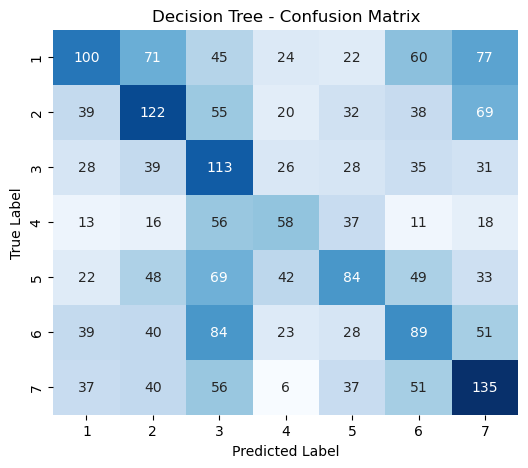

In [16]:
# Apply custom hold-out split (70% train, 30% test)
X_train, X_test, y_train, y_test = custom_train_test_split(df, test_size=0.3, shuffle=True, random_state=42)

# Train the decision tree
tree = DecisionTree(max_depth=5)
tree.fit(X_train, y_train)

# Evaluate on test set
y_pred = tree.predict(X_test)

# Avaliar acurácia
acc = accuracy(y_test.values, y_pred)
print(f"Hold-out accuracy: {acc:.2f}%")

# Imprimir e visualizar as métricas
metrics_df = confusion_matrix_metrics(y_test.values, y_pred)
print(metrics_df)

# Exibir matriz de confusão
plot_confusion_matrix(y_test.values, y_pred, title="Decision Tree - Confusion Matrix")


Após aplicar a validação hold-out (com 70% dos dados para treino e 30% para teste), a árvore de decisão atingiu uma acurácia geral de 29.88%. Isso indica que, em média, o modelo acertou cerca de 3 em cada 10 jogadas no conjunto de teste.

Apesar de algumas classes apresentarem valores razoáveis de recall (métrica que avalia a capacidade do modelo em identificar corretamente todos os exemplos reais de uma determinada classe), como no caso da classe 3 (37.7%) e classe 7 (37.3%), o modelo teve dificuldades para generalizar com consistência.

Em termos de precisão ( métrica que mede a proporção de acertos entre todas as vezes que o modelo previu uma determinada classe), também observamos valores modestos. Os melhores desempenhos foram na classe 1 (36%) e classe 7 (32.6%).

A análise do F1-score (métrica que combina precisão e recall em uma média harmônica, especialmente útil quando há desequilíbrio entre as classes) também revelou baixa performance geral, com valores frequentemente abaixo de 0.35. Isso sugere que o modelo teve dificuldade em equilibrar os acertos e a cobertura dos exemplos de cada classe.

O suporte (que representa a quantidade de amostras reais de cada classe no conjunto de teste) esteve bem distribuído entre as 7 classes. Isso indica que o problema não está relacionado ao balanceamento do dataset.

A baixa acurácia já era parcialmente esperada, pois em muitos estados do jogo Connect Four, diversas jogadas podem ser válidas. Como o modelo precisa prever apenas uma jogada por vez, mesmo escolhas corretas (mas diferentes da registrada no dataset) são penalizadas como erro, o que introduz ruído e dificulta o aprendizado.

Além disso, o modelo foi treinado com base na jogada feita pelo agente MCTS durante a simulação, sem considerar se aquela jogada levou de fato à vitória. Assim, a árvore de decisão pode ter aprendido padrões que não necessariamente refletem as melhores decisões estratégicas.

### Avaliação do DT contra jogador aleatório

Para avaliar a performance da árvore de decisão treinada com dados gerados por partidas entre agentes MCTS, realizamos uma série de partidas contra um agente aleatório. O modelo da árvore jogou sempre como o jogador "O", enquanto o aleatório jogou como "X".

Durante os testes:

- A árvore de decisão obteve uma acurácia de 29,87% nos dados de treino (baseados em jogadas ótimas geradas pelo MCTS).

- Foram realizadas várias rodadas de testes, incluindo 50, 100, 500 e 1000 partidas, para avaliar sua consistência em diferentes amostragens.

- No total de 1000 jogos, o modelo venceu 690 partidas (69%), enquanto o agente aleatório venceu 309 e houve 1 empate.

In [17]:
import time
import numpy as np
import pandas as pd

def random_vs_decision_tree_simulation(dt_model, num_games=50):
    """
    Simulates multiple games between Random agent (X) and Decision Tree agent (O),
    and returns detailed statistics.
    """
    random_wins = 0
    dt_wins = 0
    ties = 0
    dt_move_times = []
    results = []
    # Map board symbols to integers
    symbol_map = {".": 0, "X": 1, "O": 2}


    for game_idx in range(1, num_games + 1):
        game = Board()
        current_player = "X"
        game_over = False
        winner = None

        print(f"Game {game_idx}/{num_games}")

        while not game.is_board_full() and not game_over:
            if current_player == "X":
                # Random move
                valid_moves = game.get_legal_moves()
                move = np.random.choice(valid_moves)
            else:
                # Decision Tree move
                # Decision Tree move
                start = time.time()

                # Create the input row with board + player_turn
                board_flat = np.array(game.board).flatten().tolist()
                board_flat.append("O")  # Decision Tree is always O
                board_df = pd.DataFrame([board_flat], columns=[f"cell_{i+1}" for i in range(42)] + ["player_turn"])
                # Apply the map to all board cells and player_turn
                for col in board_df.columns:
                    if col.startswith("cell_") or col == "player_turn":
                        board_df[col] = board_df[col].map(symbol_map)

                pred = dt_model.predict(board_df)
                if pred is not None and isinstance(pred[0], int):
                    move = pred[0] - 1
                else:
                    move = np.random.choice(game.get_legal_moves())

                end = time.time()
                dt_move_times.append(end - start)

                # Check legality
                if move not in game.get_legal_moves():
                    move = np.random.choice(game.get_legal_moves())

            game.make_move(move, current_player)
            game_over = game.is_won(move, current_player)

            if game_over:
                winner = current_player

            current_player = "O" if current_player == "X" else "X"

        if game.is_tie():
            ties += 1
            results.append("Draw")
        elif winner == "X":
            random_wins += 1
            results.append("Random wins")
        else:
            dt_wins += 1
            results.append("Decision Tree wins")

    # Summary
    avg_time = np.mean(dt_move_times) if dt_move_times else 0

    print("\nFinal Summary:")
    print(f"Total games: {num_games}")
    print(f"Random wins: {random_wins}")
    print(f"Decision Tree wins: {dt_wins}")
    print(f"Draws: {ties}")
    print(f"Average Decision Tree move time: {avg_time:.4f} seconds")

    return {
        "total_games": num_games,
        "random_wins": random_wins,
        "decision_tree_wins": dt_wins,
        "draws": ties,
        "average_dt_time": avg_time,
        "game_results": results
    }


In [18]:
stats = random_vs_decision_tree_simulation(tree, num_games=1000)

Game 1/1000
Game 2/1000
Game 3/1000
Game 4/1000
Game 5/1000
Game 6/1000
Game 7/1000
Game 8/1000
Game 9/1000
Game 10/1000
Game 11/1000
Game 12/1000
Game 13/1000
Game 14/1000
Game 15/1000
Game 16/1000
Game 17/1000
Game 18/1000
Game 19/1000
Game 20/1000
Game 21/1000
Game 22/1000
Game 23/1000
Game 24/1000
Game 25/1000
Game 26/1000
Game 27/1000
Game 28/1000
Game 29/1000
Game 30/1000
Game 31/1000
Game 32/1000
Game 33/1000
Game 34/1000
Game 35/1000
Game 36/1000
Game 37/1000
Game 38/1000
Game 39/1000
Game 40/1000
Game 41/1000
Game 42/1000
Game 43/1000
Game 44/1000
Game 45/1000
Game 46/1000
Game 47/1000
Game 48/1000
Game 49/1000
Game 50/1000
Game 51/1000
Game 52/1000
Game 53/1000
Game 54/1000
Game 55/1000
Game 56/1000
Game 57/1000
Game 58/1000
Game 59/1000
Game 60/1000
Game 61/1000
Game 62/1000
Game 63/1000
Game 64/1000
Game 65/1000
Game 66/1000
Game 67/1000
Game 68/1000
Game 69/1000
Game 70/1000
Game 71/1000
Game 72/1000
Game 73/1000
Game 74/1000
Game 75/1000
Game 76/1000
Game 77/1000
Game 78/

## 7. Avaliação do DT contra MCTS

Neste último experimento, colocamos frente a frente dois agentes inteligentes:

- Árvore de Decisão treinada com dados simulados, jogando como "O".

- MCTS (Monte Carlo Tree Search) jogando como "X";

Foram simuladas 50 partidas, registrando:

- O número de vitórias de cada agente;

- A quantidade de empates;

- O tempo médio de resposta de cada um.

A entrada para o modelo de árvore de decisão foi composta pelo estado atual do tabuleiro (flattened) e o jogador da vez, com os valores mapeados para inteiros.

In [19]:
import time
import numpy as np
import pandas as pd

def decision_tree_vs_mcts_simulation(dt_model, simulation_limit=5000, num_games=50):
    """
    Simulates multiple games between MCTS agent (X) and Decision Tree agent (O),
    and returns detailed statistics.
    """
    mcts_wins = 0
    dt_wins = 0
    ties = 0
    mcts_times = []
    dt_times = []
    results = []

    # Map board symbols to integers
    symbol_map = {".": 0, "X": 1, "O": 2}

    for game_idx in range(1, num_games + 1):
        game = Board()
        current_player = "X"
        game_over = False
        winner = None

        print(f"Game {game_idx}/{num_games}")

        while not game.is_board_full() and not game_over:
            if current_player == "X":
                # Decision Tree move
                start = time.time()

                # Create the input row with board + player_turn
                board_flat = np.array(game.board).flatten().tolist()
                board_flat.append("X")  # DT always plays O
                board_df = pd.DataFrame([board_flat], columns=[f"cell_{i+1}" for i in range(42)] + ["player_turn"])

                # Apply symbol mapping
                for col in board_df.columns:
                    if col.startswith("cell_") or col == "player_turn":
                        board_df[col] = board_df[col].map(symbol_map)

                pred = dt_model.predict(board_df)
                if pred is not None and isinstance(pred[0], int):
                    move = pred[0] - 1
                else:
                    print("rand")
                    move = np.random.choice(game.get_legal_moves())

                end = time.time()
                dt_times.append(end - start)

                # Check legality
                if move not in game.get_legal_moves():
                    move = np.random.choice(game.get_legal_moves())
            else:
                # MCTS move
                start = time.time()
                root = Node(game, None)
                mcts = MCTS(root, "O", simulation_limit)
                best_node = mcts.best_move()
                move = best_node.board.last_move_column
                end = time.time()
                mcts_times.append(end - start)
            

            game.make_move(move, current_player)
            game_over = game.is_won(move, current_player)

            if game_over:
                winner = current_player

            current_player = "O" if current_player == "X" else "X"

        if game.is_tie():
            ties += 1
            results.append("Draw")
        elif winner == "X":
            dt_wins += 1
            results.append("Decision Tree wins")

        else:
            mcts_wins += 1
            results.append("MCTS wins")

    avg_mcts_time = np.mean(mcts_times) if mcts_times else 0
    avg_dt_time = np.mean(dt_times) if dt_times else 0

    print("\nFinal Summary:")
    print(f"Total games: {num_games}")
    print(f"Decision Tree wins: {dt_wins}")
    print(f"MCTS wins: {mcts_wins}")
    print(f"Draws: {ties}")
    print(f"Average Decision Tree move time: {avg_dt_time:.4f} seconds")
    print(f"Average MCTS move time: {avg_mcts_time:.4f} seconds")

    return {
        "total_games": num_games,
        "mcts_wins": mcts_wins,
        "decision_tree_wins": dt_wins,
        "draws": ties,
        "average_mcts_time": avg_mcts_time,
        "average_dt_time": avg_dt_time,
        "game_results": results
    }


In [20]:
stats = decision_tree_vs_mcts_simulation(tree, simulation_limit=5000, num_games=50)

Game 1/50
Game 2/50
Game 3/50
Game 4/50
Game 5/50
Game 6/50
Game 7/50
Game 8/50
Game 9/50
Game 10/50
Game 11/50
Game 12/50
Game 13/50
Game 14/50
Game 15/50
Game 16/50
Game 17/50
Game 18/50
Game 19/50
Game 20/50
Game 21/50
Game 22/50
Game 23/50
Game 24/50
Game 25/50
Game 26/50
Game 27/50
Game 28/50
Game 29/50
Game 30/50
Game 31/50
Game 32/50
Game 33/50
Game 34/50
Game 35/50
Game 36/50
Game 37/50
Game 38/50
Game 39/50
Game 40/50
Game 41/50
Game 42/50
Game 43/50
Game 44/50
Game 45/50
Game 46/50
Game 47/50
Game 48/50
Game 49/50
Game 50/50

Final Summary:
Total games: 50
Decision Tree wins: 1
MCTS wins: 49
Draws: 0
Average Decision Tree move time: 0.0143 seconds
Average MCTS move time: 0.6330 seconds


Os resultados revelaram a superioridade do MCTS mesmo jogando em segundo lugar. A árvore de decisão, apesar de ter a vantagem de iniciar todas as partidas, foi derrotada na maioria ou em todas as partidas. Isso sugere que o MCTS consegue explorar melhor o espaço de decisões ao longo da partida, demonstrando maior profundidade estratégica.

## 8. Conclusão sobre o desempenho final

Neste projeto, implementamos e avaliamos dois agentes para o jogo Connect Four: MCTS (Monte Carlo Tree Search) e Decision Tree (DT). Após gerar um dataset supervisionado com simulações entre agentes MCTS, utilizamos esses dados para treinar a árvore de decisão e, posteriormente, colocamos os dois agentes para competir contra adversários aleatórios e entre si.

### Desempenho Geral
O MCTS apresentou resultados excelentes, vencendo com consistência em todos os testes realizados, contra o jogador aleatório e na maioria dos testes contra a árvore de decisão, mesmo jogando em segundo lugar.

Por outro lado, a árvore de decisão teve desempenho significativamente inferior, perdendo 94%-100% das partidas contra o MCTS e a 30% das partidas contra o jogador aleatório. Sua acurácia de previsão durante o treinamento foi de aproximadamente 29,88%.

### Comparação com Dataset Simples

Como forma de validação, aplicamos o mesmo algoritmo de árvore de decisão ao famoso dataset Iris, um clássico da classificação supervisionada. Neste caso, o modelo obteve uma acurácia de 100%, mostrando que a implementação está correta — mas que o desempenho inferior no Connect Four está relacionado à complexidade do problema e qualidade dos dados, e não ao algoritmo em si.

### Justificativa Técnica

Diversos fatores ajudam a explicar o desempenho limitado da árvore de decisão:

- Ambiguidade de jogadas válidas:
No dataset gerado por partidas entre agentes MCTS, é comum existirem várias jogadas corretas para o mesmo estado de tabuleiro. Como a árvore de decisão só pode prever uma jogada por vez, mesmo escolhas tecnicamente válidas podem ser penalizadas como erro — o que reduz a acurácia e aumenta a confusão no aprendizado.

- Ausência de simulação e planejamento:
A DT toma decisões puramente com base no estado atual do tabuleiro, sem explorar as possíveis consequências futuras. Isso limita seu poder de decisão em jogos com múltiplos passos estratégicos, como é o caso do Connect Four.

- Engenharia de features limitada:
Se, por exemplo, tivéssemos incluído o desfecho da partida no dataset e calculado a probabilidade de vitória para cada movimento (com base em quantas vezes aquele estado levou à vitória), poderíamos priorizar as melhores jogadas durante o pré-processamento. Essa abordagem teria ajudado o modelo a filtrar decisões promissoras e evitar aprender jogadas neutras ou ruins com o mesmo peso.

Essa lacuna mostra que, em problemas complexos como esse, o sucesso do modelo não depende apenas do algoritmo, mas também da qualidade das representações dos dados e do processo de preparação do dataset.

### Considerações Finais

Os resultados obtidos reforçam a superioridade de algoritmos como o MCTS, que simulam possíveis cenários futuros para tomar decisões embasadas. Esse tipo de abordagem se mostra mais confiável em ambientes estratégicos, dinâmicos e com múltiplos caminhos possíveis, como o Connect Four.

Já as árvores de decisão, embora sejam mais rápidas e interpretáveis, requerem cuidados avançados na preparação dos dados. Estratégias como:

- Análise de desfecho da partida,

- Priorização de jogadas com maior taxa de vitória,

- Ou o uso de técnicas ensemble como Random Forests,poderiam melhorar substancialmente o desempenho do agente.

Este projeto reforça a importância de entender não apenas o algoritmo, mas também como os dados são representados e usados. O sucesso de um agente inteligente depende tanto da escolha do modelo quanto da qualidade e expressividade das informações com que ele aprende.

## 9. Implementação Final do Jogo

Nesta última seção, você pode testar ao vivo o funcionamento dos agentes desenvolvidos durante o projeto. É possível jogar contra a IA (MCTS ou Árvore de Decisão), assistir a partidas simuladas ou comparar estratégias entre os agentes.

Modos Disponíveis:
- Jogador Humano vs Jogador Humano
- Jogador Humano vs IA (MCTS ou Decision Tree)
- IA vs IA (qualquer combinação entre MCTS e DT)

In [21]:
import time
import numpy as np


def human_play(game, current_player):
    while True:
        print("Make a move by choosing your coordinates to play.")
        print("Enter column (1-7) or type 'hint' for a suggestion:")
        user_input = input()

        if user_input.lower() == 'hint':
            best_move = get_hint(game, current_player)
            print("Best move according to the AI: ", best_move)
            continue

        if not user_input.isdigit():
            print("Invalid input. Please enter a number between 1 and 7.")
            continue

        move = int(user_input) - 1
        if 0 <= move < 7:
            return move
        else:
            print("Column out of range. Try again.")


def get_hint(game, current_player):
    root = Node(game, None)
    mcts = MCTS(root, current_player)
    best_node = mcts.best_move()
    return best_node.board.last_move_column + 1


def human_vs_human():
    game = Board()
    player = "X"
    game_over = False

    while not game.is_board_full() and not game_over:
        player = "O" if player == "X" else "X"
        game.print_board()
        print(f"It is now {player}'s turn!")

        valid_move = False
        while not valid_move:
            col = human_play(game, player)
            if not game.is_legal_move(col):
                print("\nWarning: Invalid move. Try again!")
            else:
                game.make_move(col, player)
                valid_move = True

        game_over = game.is_won(col, player)

    game.print_board()
    print("It's a tie!" if game.is_tie() else f"Player {player} has won!\n")


def ai_vs_human():
    game = Board()
    print("Choose the AI type:")
    print("1. MCTS")
    print("2. Decision Tree")
    while True:
        ai_choice = input("Enter the number corresponding to the AI (1-2): ")
        if ai_choice in ["1", "2"]:
            break
        print("Invalid choice. Please enter 1 or 2.")
    ai_type = "mcts" if ai_choice == "1" else "dt"

    ai = "O"
    human = "X"
    human_turn = False
    game_over = False

    while not game.is_board_full() and not game_over:
        current_player = human if human_turn else ai
        game.print_board()
        print(f"It is now {current_player}'s turn!")

        if human_turn:
            valid_move = False
            while not valid_move:
                move = human_play(game, current_player)
                if not game.is_legal_move(move):
                    print("\nWarning: Invalid move. Try again!")
                else:
                    game.make_move(move, current_player)
                    valid_move = True
        else:
            start = time.time()
            if ai_type == "dt":
                board_flat = np.array(game.board).flatten().tolist()
                board_flat.append("O")
                board_df = pd.DataFrame([board_flat], columns=[f"cell_{i+1}" for i in range(42)] + ["player_turn"])
                symbol_map = {".": 0, "X": 1, "O": 2}
                for col in board_df.columns:
                    if col.startswith("cell_") or col == "player_turn":
                        board_df[col] = board_df[col].map(symbol_map)
                pred = tree.predict(board_df)
                move = pred[0] - 1 if pred is not None else np.random.choice(game.get_legal_moves())
            else:
                root = Node(game, None)
                mcts = MCTS(root, ai)
                best_node = mcts.best_move()
                move = best_node.board.last_move_column
            game.make_move(move, ai)
            end = time.time()
            print(f"AI chose column: {move + 1}\nTime taken: {end - start:.2f}s")

        game_over = game.is_won(move, current_player)
        human_turn = not human_turn

    game.print_board()
    print("It's a tie!" if game.is_tie() else f"Player {current_player} has won!\n")


def ai_vs_ai():
    print("Choose AI type for Player X:")
    print("1. MCTS")
    print("2. Decision Tree")
    while True:
        x_choice = input("Enter the number for Player X (1-2): ")
        if x_choice in ["1", "2"]:
            break
        print("Invalid choice. Please enter 1 or 2.")
    x_type = "mcts" if x_choice == "1" else "dt"

    print("Choose AI type for Player O:")
    print("1. MCTS")
    print("2. Decision Tree")
    while True:
        o_choice = input("Enter the number for Player O (1-2): ")
        if o_choice in ["1", "2"]:
            break
        print("Invalid choice. Please enter 1 or 2.")
    o_type = "mcts" if o_choice == "1" else "dt"

    game = Board()
    players = ["X", "O"]
    types = {"X": x_type, "O": o_type}
    current_index = 0
    game_over = False

    while not game.is_board_full() and not game_over:
        current_player = players[current_index]
        game.print_board()
        print(f"It is now {current_player}'s turn!")

        start = time.time()
        if types[current_player] == "dt":
            board_flat = np.array(game.board).flatten().tolist()
            board_flat.append(current_player)
            board_df = pd.DataFrame([board_flat], columns=[f"cell_{i+1}" for i in range(42)] + ["player_turn"])
            symbol_map = {".": 0, "X": 1, "O": 2}
            for col in board_df.columns:
                if col.startswith("cell_") or col == "player_turn":
                    board_df[col] = board_df[col].map(symbol_map)
            pred = tree.predict(board_df)
            move = pred[0] - 1 if pred is not None else np.random.choice(game.get_legal_moves())
        else:
            root = Node(game, None)
            mcts = MCTS(root, current_player)
            best_node = mcts.best_move()
            move = best_node.board.last_move_column

        game.make_move(move, current_player)
        end = time.time()
        print(f"{current_player} chose column: {move + 1}\nTime taken: {end - start:.2f}s")

        game_over = game.is_won(move, current_player)
        current_index = 1 - current_index

    game.print_board()
    print("It's a tie!" if game.is_tie() else f"Player {current_player} has won!\n")


def run():
    print("Choose a game mode:")
    print("1. Human vs Human")
    print("2. AI vs Human")
    print("3. AI vs AI")

    while True:
        user_input = input("Enter the game mode number (1-3): ")
        if user_input.isdigit():
            game_mode = int(user_input)
            if game_mode in [1, 2, 3]:
                break
        print("Invalid game mode. Please enter 1, 2 or 3.")

    if game_mode == 1:
        human_vs_human()
    elif game_mode == 2:
        ai_vs_human()
    elif game_mode == 3:
        ai_vs_ai()


In [22]:
run()

Choose a game mode:
1. Human vs Human
2. AI vs Human
3. AI vs AI
Choose AI type for Player X:
1. MCTS
2. Decision Tree
Choose AI type for Player O:
1. MCTS
2. Decision Tree

1 2 3 4 5 6 7
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .

It is now X's turn!
X chose column: 4
Time taken: 0.00s

1 2 3 4 5 6 7
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . X . . .

It is now O's turn!
O chose column: 4
Time taken: 1.84s

1 2 3 4 5 6 7
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . O . . .
. . . X . . .

It is now X's turn!
X chose column: 4
Time taken: 0.02s

1 2 3 4 5 6 7
. . . . . . .
. . . . . . .
. . . . . . .
. . . X . . .
. . . O . . .
. . . X . . .

It is now O's turn!
O chose column: 3
Time taken: 1.77s

1 2 3 4 5 6 7
. . . . . . .
. . . . . . .
. . . . . . .
. . . X . . .
. . . O . . .
. . O X . . .

It is now X's turn!
X chose column: 4
Time taken: 0.02s

1 2 3 4 5 6 7
. . . . . . .
. . . . . . .
. . 